

##############################################################################################
### EGGS - Entropy of Gene Group Shuffling - Jupyter Notebook Analysis Pipeline.
###       - Version v1.0.0.
##############################################################################################
### Cite the following pre-print (or follow-up publication associated with it):
###    Chromosome-scale scaffolding of the fungus gnat genome (Diptera: Bradysia coprophila)
###    John M. Urban, Susan A. Gerbi, Allan C. Spradling
###    bioRxiv 2022.11.03.515061; doi: https://doi.org/10.1101/2022.11.03.515061
##############################################################################################
### The first published version, used in the published paper, is part of the code section of:
###   - https://github.com/JohnUrban/Bcop_v2
### Updates to it will be hosted at: https://github.com/JohnUrban/EGGS
##############################################################################################

In [1]:
import os, sys
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import importlib
from scipy.cluster.hierarchy import linkage, dendrogram, optimal_leaf_ordering


# importlib.reload()

/Users/jurban/software/conda/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Check PWD

In [2]:
!pwd

/Users/jurban/software/Bcop_v2/dev/EGGS/EGGS


# Add EGGS functions to PATH, and import them.

In [4]:
sys.path.insert(0, "/Users/jurban/software/Bcop_v2/EGGS/EGGS")       

## Import

In [5]:
from EGGS import *

In [6]:
import EGGS
importlib.reload( EGGS )
from EGGS import *

In [7]:
version


'1.0.0'

In [8]:
print(help_string)


Current Version: 1.0.0

Author: John M. Urban.

version 1.0
- Needed functions for reproducing Bcop_v2 paper EGGS analyses were copied from John Urban's orthoChainLinkerUtilities.py version 0.4.0.





# Set up some variables and parameters

In [15]:
spp     = ["bcop","bhyg","aedes","anoph","dmel"]
nspp    = len(spp)
input1  = "proteomes/OrthoFinder/Results_Oct10/Orthogroups/Orthogroups_SingleCopyOrthologues.tsv"
chrlist = ('X','II','III','IV','X','A','B','C', 'chr2L', 'chr2R', 'chr3L','chr3R','chr4','chrX', 'chr1','chr2','chr3')
pseudo  = 0.1

In [16]:
ObsJointEntropyMat = np.zeros([nspp,nspp])
ExpJointEntropyMat = np.zeros([nspp,nspp])
MMNEp = np.zeros([nspp,nspp])
MMNE = np.zeros([nspp,nspp])
MMNE

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [17]:
spaf_dict = {}

# Run loop over all pairwise species comparisons to compute various entropy scores.
- This code does brute force redundant computations since the pair A,B is the same as the pair B,A.
- It does this here simply to show that it behaves as expected, producing the same various entropy scores in both directions.
- See more efficient loop at the end that skips redundant calculations.
- Due to various overflow/underflow issues, the results slightly differ, but only by differences <1e-15.

In [18]:
importlib.reload( EGGS )
from EGGS import *
pseudo  = 0.1
chrlist = ('X','II','III','IV','X','A','B','C', 'chr2L', 'chr2R', 'chr3L','chr3R','chr4','chrX', 'chr1','chr2','chr3')

for i in range(nspp):
    for j in range(nspp): ## entropy is same result in both dir, so this could be "for j in range(i,nspp)"; and below can do mat[j,i] = mat[i,j]
        ## Gather species info
        pre1 = spp[i]
        pre2 = spp[j]
        print("Processing " + pre1 + " vs " + pre2 + " ...")
        
        ## Construct SimplePaf
        sp1 = SpeciesFiles(pre1, shared_dir="./")
        sp2 = SpeciesFiles(pre2, shared_dir="./")
        spaf = SimplePaf(sp1, 
                         sp2, 
                         input1, 
                         pseudo=pseudo,
                         sp1_chr_names=chrlist,
                         sp2_chr_names=chrlist,
                         strip_sp1_names=True,
                         strip_sp2_names=True)

        ## Store SimplePaf object
        spaf_dict[pre1+'_'+pre2] = spaf
              
        # Add to Matrixes
        ## Observed Raw Entropy - just showing user how to get this, not for plots in paper.
        ObsJointEntropyMat[i,j]      = spaf.get_joint_entropy()
        ## Expected Raw Entropy - just showing user how to get this, not for plots in paper.
        ExpJointEntropyMat[i,j]  = spaf.get_random_joint_entropy()
        ## Min Max Normalized Entropy as computed for paper
        MMNE[i,j] = spaf.get_joint_entropy_minmax_normalized_margin_approach()
        ## Alternative computation to get Min Max Normalized Entropy as computed for paper
        MMNEp[i,j] = spaf.get_joint_entropy_minmax_normalized_margin_approach_perfect()

    
    
## show it
MMNE

Processing bcop vs bcop ...
Processing bcop vs bhyg ...
Processing bcop vs aedes ...
Processing bcop vs anoph ...
Processing bcop vs dmel ...
Processing bhyg vs bcop ...
Processing bhyg vs bhyg ...
Processing bhyg vs aedes ...
Processing bhyg vs anoph ...
Processing bhyg vs dmel ...
Processing aedes vs bcop ...
Processing aedes vs bhyg ...
Processing aedes vs aedes ...
Processing aedes vs anoph ...
Processing aedes vs dmel ...
Processing anoph vs bcop ...
Processing anoph vs bhyg ...
Processing anoph vs aedes ...
Processing anoph vs anoph ...
Processing anoph vs dmel ...
Processing dmel vs bcop ...
Processing dmel vs bhyg ...
Processing dmel vs aedes ...
Processing dmel vs anoph ...
Processing dmel vs dmel ...


array([[0.00209206, 0.10326666, 0.64949466, 0.74419566, 0.86497917],
       [0.10326666, 0.00239775, 0.64891403, 0.74387462, 0.86113221],
       [0.64949466, 0.64891403, 0.00137171, 0.81010903, 0.88569169],
       [0.74419566, 0.74387462, 0.81010903, 0.00157597, 0.86695698],
       [0.86497917, 0.86113221, 0.88569169, 0.86695698, 0.00252544]])

## Both ways of computing MMNE above give same results

In [51]:
MMNE_mat = MMNE ## Preserving this matrix to compare to "efficient loop" results far below.
MMNEp_mat = MMNEp ## Preserving this matrix to compare to MMNE_mat next line below.

In [52]:
(MMNE_mat-MMNEp_mat) < 1e-300

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

# Need to convert to Pandas DataFrames for clustermap and barplots below

In [53]:
ObsJointEntropyMat  = pd.DataFrame(ObsJointEntropyMat, columns=spp, index=spp)
ExpJointEntropyMat  = pd.DataFrame(ExpJointEntropyMat, columns=spp, index=spp)
MMNE                = pd.DataFrame(MMNE, columns=spp, index=spp)
MMNEp               = pd.DataFrame(MMNEp, columns=spp, index=spp)

In [61]:
cmap = matplotlib.cm.get_cmap('viridis',4192)
MMNE_barplot_df = pd.DataFrame(dict(x=MMNE.columns,y=MMNE.iloc[0,:]))
rgba = [cmap(e) for e in MMNE_barplot_df['y'] ]
rgba

[(0.267004, 0.004874, 0.329415, 1.0),
 (0.28229, 0.145912, 0.46151, 1.0),
 (0.185783, 0.704891, 0.485273, 1.0),
 (0.35236, 0.783011, 0.392636, 1.0),
 (0.647257, 0.8584, 0.209861, 1.0)]

# Barplot from the paper

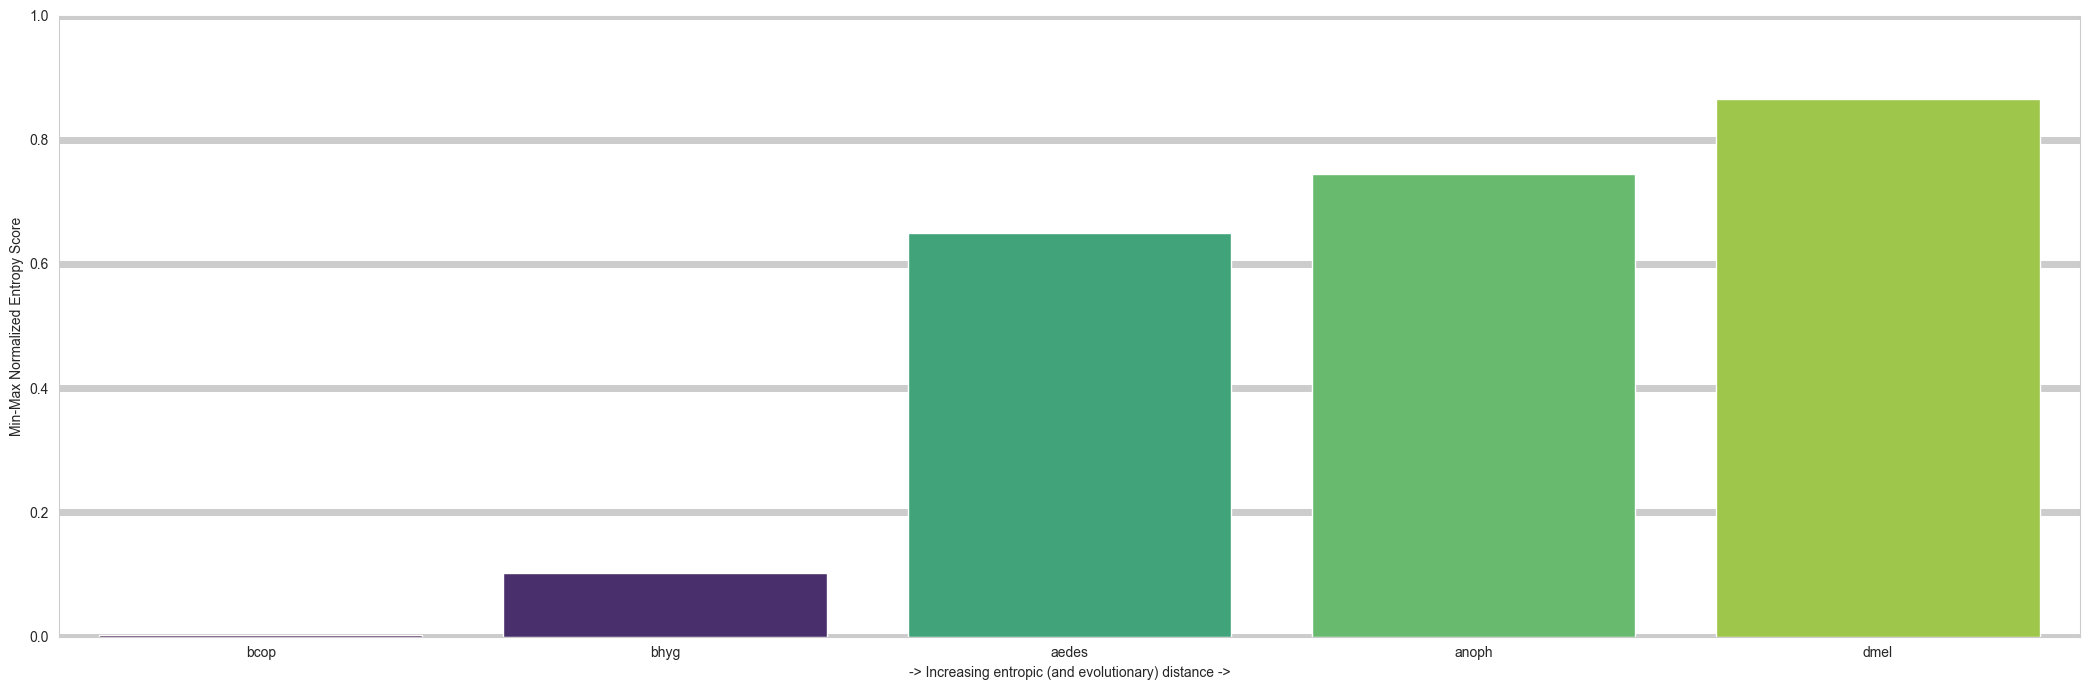

In [62]:
sns.set_style(style="whitegrid")

sns.set_context(rc={"grid.linewidth":5})

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(21,7))
sns.barplot(data = MMNE_barplot_df, x='x', y='y', palette=rgba, ax = ax)


plt.ylim(0, 1)
plt.xlim(-0.5, 4.5)
plt.ylabel("Min-Max Normalized Entropy Score")
plt.xlabel("-> Increasing entropic (and evolutionary) distance ->")


plt.tight_layout()
# plt.savefig("barplot-gridlines-20231016.pdf")
# plt.savefig("barplot-gridlines-20231016.jpg")

# ClusterMap / Dendrogram HeatMap from paper

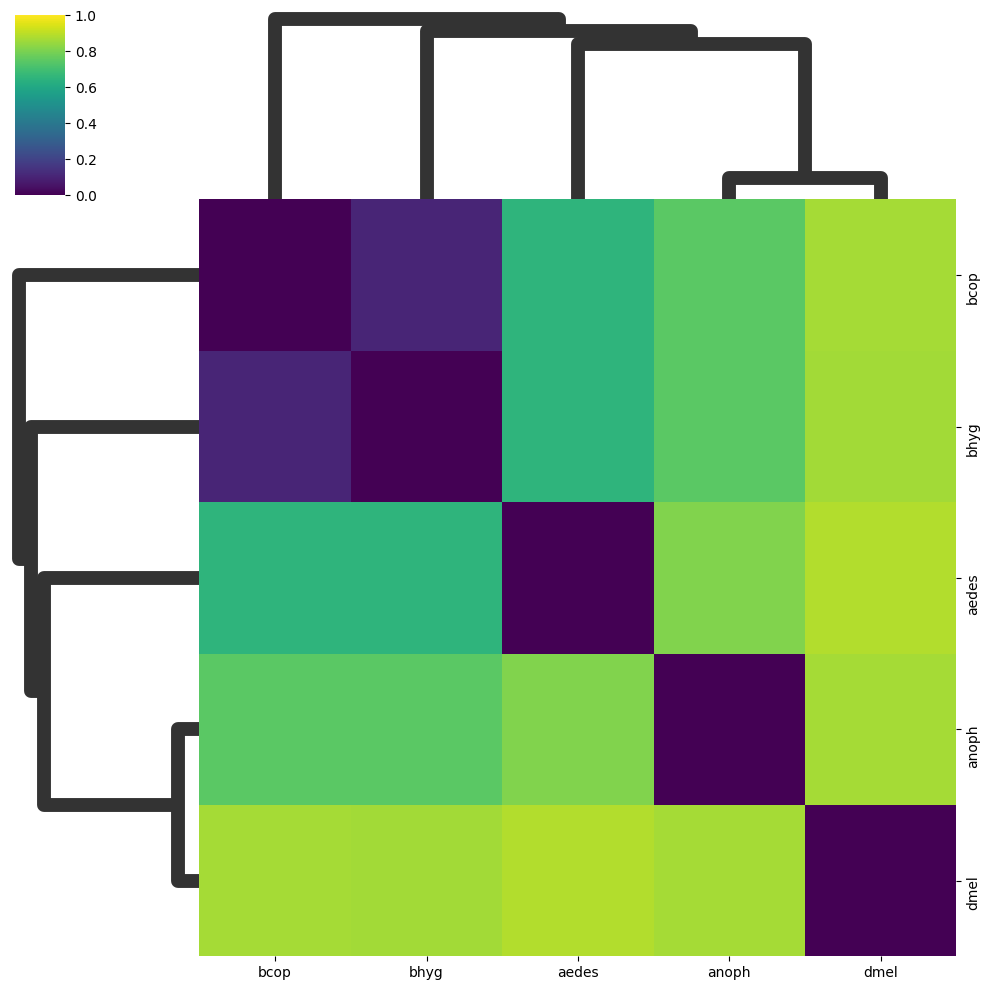

In [58]:
row_col_links = linkage(MMNE, method="single", metric="euclidean")
optord = optimal_leaf_ordering(row_col_links, MMNE)
g = sns.clustermap(MMNE, 
                   row_linkage=optord, 
                   col_linkage=optord, 
                   cmap="viridis", 
                   vmin=0, vmax=1, 
                   tree_kws=dict(linewidths=10)) 
# Flip the heatmap
g.ax_heatmap.invert_yaxis()
g.ax_heatmap.invert_xaxis()
plt.show()

# More efficient loop over all pairwise species comparisons to compute various entropy scores.
- This code does more efficient computations over all pairs since the pair A,B is the same as the pair B,A.
- Due to various overflow/underflow issues, the results slightly differ, but only by differences <1e-15.
- Variable names given "e" prefix to not write-over variables computed above, and denotes these are from the "efficient" loop.

In [19]:
eObsJointEntropyMat = np.zeros([nspp,nspp])
eExpJointEntropyMat = np.zeros([nspp,nspp])
eMMNEp = np.zeros([nspp,nspp])
eMMNE = np.zeros([nspp,nspp])
eMMNE
espaf_dict = {}

In [22]:
importlib.reload( EGGS )
from EGGS import *
pseudo  = 0.1
chrlist = ('X','II','III','IV','X','A','B','C', 'chr2L', 'chr2R', 'chr3L','chr3R','chr4','chrX', 'chr1','chr2','chr3')

for i in range(nspp):
    for j in range(i, nspp): ## entropy is same result in both dir, so this could be "for j in range(i,nspp)"; and below can do mat[j,i] = mat[i,j]
        ## Gather species info
        pre1 = spp[i]
        pre2 = spp[j]
        print("Processing " + pre1 + " vs " + pre2 + " ...")
        
        ## Construct SimplePaf
        sp1 = SpeciesFiles(pre1, shared_dir="./")
        sp2 = SpeciesFiles(pre2, shared_dir="./")
        spaf = SimplePaf(sp1, 
                         sp2, 
                         input1, 
                         pseudo=pseudo,
                         sp1_chr_names=chrlist,
                         sp2_chr_names=chrlist,
                         strip_sp1_names=True,
                         strip_sp2_names=True)

        ## Store SimplePaf object
        espaf_dict[pre1+'_'+pre2] = spaf
              
        # Add to Matrixes
        ## Observed Raw Entropy - just showing user how to get this, not for plots in paper.
        eObsJointEntropyMat[i,j]      = spaf.get_joint_entropy()
        eObsJointEntropyMat[j,i]      = spaf.get_joint_entropy()
        ## Expected Raw Entropy - just showing user how to get this, not for plots in paper.
        eExpJointEntropyMat[i,j]  = spaf.get_random_joint_entropy()
        eExpJointEntropyMat[j,i]  = spaf.get_random_joint_entropy()
        ## Min Max Normalized Entropy as computed for paper
        eMMNE[i,j] = spaf.get_joint_entropy_minmax_normalized_margin_approach()
        eMMNE[j,i] = spaf.get_joint_entropy_minmax_normalized_margin_approach()
        ## Alternative computation to get Min Max Normalized Entropy as computed for paper
        eMMNEp[i,j] = spaf.get_joint_entropy_minmax_normalized_margin_approach_perfect()
        eMMNEp[j,i] = spaf.get_joint_entropy_minmax_normalized_margin_approach_perfect()

    
    
## show it
eMMNE

Processing bcop vs bcop ...
Processing bcop vs bhyg ...
Processing bcop vs aedes ...
Processing bcop vs anoph ...
Processing bcop vs dmel ...
Processing bhyg vs bhyg ...
Processing bhyg vs aedes ...
Processing bhyg vs anoph ...
Processing bhyg vs dmel ...
Processing aedes vs aedes ...
Processing aedes vs anoph ...
Processing aedes vs dmel ...
Processing anoph vs anoph ...
Processing anoph vs dmel ...
Processing dmel vs dmel ...


array([[0.00209206, 0.10326666, 0.64949466, 0.74419566, 0.86497917],
       [0.10326666, 0.00239775, 0.64891403, 0.74387462, 0.86113221],
       [0.64949466, 0.64891403, 0.00137171, 0.81010903, 0.88569169],
       [0.74419566, 0.74387462, 0.81010903, 0.00157597, 0.86695698],
       [0.86497917, 0.86113221, 0.88569169, 0.86695698, 0.00252544]])

# Differences between brute force and more efficient are all less than 0.000000000000001 (1e-15)

In [36]:
(MMNE_mat-eMMNE) < 1e-15

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])